# Autodiff: Calculus  from another angle 

  


We know differentiation
<img src="http://image.mathcaptain.com/cms/images/122/Diff%202.png" width="150">

Then, how to differentiate using computer?

##  1. Numerical differentiation
    Finite Difference (FVM, FEM..)
    
i.e.

\begin{equation}
    f(x) = x^2 + 2x - 1
\end{equation}

Then $\dfrac{df}{dx}$?
we know the analytic solution is 
\begin{equation}
    f'(x) = 2x + 2
\end{equation}

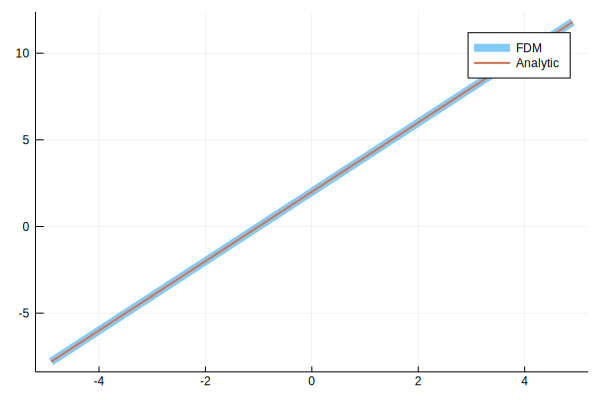

In [47]:
using Plots
gr()
#plotly()
n = 100
@. f(x) = x^2 + 2x - 1
@. fp(x) = 2x + 2
x = range(-5, 5, length=n+1)
u = f(x)
up = fp(x[2:n])
dudx = [(u[i + 1] -  u[i - 1]) / (2*(x[2] - x[1])) for i=2:n]

plot(x[2:n], dudx, linewidth=8,  alpha=0.5, label="FDM")
plot!(x[2:n], up, linewidth=2,  alpha=1, label="Analytic")

* Pros : Simple implmenetation
* Cons : Not accurate if high order or few grid points

## 2. Symbolic Differentiation

Mathematica way

In [52]:
#import Pkg; Pkg.add("SymPy")
using SymPy

In [51]:

@vars x
diff(cos(x), x)

ArgumentError: ArgumentError: ref of NULL PyObject

In [3]:
diff( x^2 + 2x - 1, x)

UndefVarError: UndefVarError: x not defined

* Pros : Accurate
* Cons : Very slow or even not applicable to complex function

## 3. Auto differentiation

  
Let's start with $\sqrt{x}$

## Babylonian sqrt

1. Make an initial guess. $x_0$
2. Improve the guess. $x1 = (x0 + S / x0) / 2$
3. Iterate until convergence. $x_{n+1} = (x_n + S / x_n) /2 $

More algorithmic way

 > Repeat $ t \leftarrow  (t+x/t) / 2 $ until $t$ converges to $\sqrt{x}$.
 
 Next Each iteration has one add and two divides. For illustration purposes, 10 iterations suffice.

In [4]:
function Babylonian(x; N = 10) 
    t = (1+x)/2
    for i = 2:N; t=(t + x/t)/2  end    
    t
end

Babylonian (generic function with 1 method)

Check that it works:

In [5]:
α = π
Babylonian(α), √α

(1.7724538509055159, 1.7724538509055159)

In [6]:
x=2; Babylonian(x),√x  # Type \sqrt+<tab> to get the symbol

(1.414213562373095, 1.4142135623730951)

In [49]:
using Plots
gr()

Plots.GRBackend()

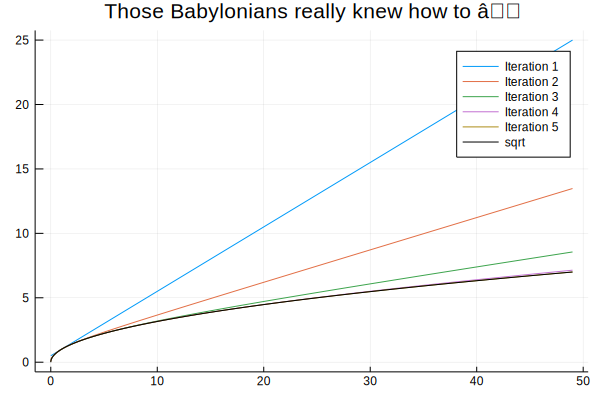

In [50]:
## Warning first plots load packages, takes time
i = 0:.01:49

plot([x->Babylonian(x,N=i) for i=1:5],i,label=["Iteration $j" for i=1:1,j=1:5])

plot!(sqrt,i,c="black",label="sqrt",
      title = "Those Babylonians really knew how to √")

## ...and now the derivative, almost by magic

we have a derivatve of `sqrt(x)`

\begin{equation}
(\sqrt{x})' = (x^{\frac{1}{2}})' = \dfrac{1}{2 \sqrt{x}}
\end{equation}

Introduce Dual number,  invented by the famous algebraist Clifford in 1873, as `D`.

In [9]:
struct D <: Number  # D is a function-derivative pair
    # D = (Number (func), Number (derivative))
    f::Tuple{Float64,Float64}
end

* Sum Rule
\begin{equation}
    (x+y)' = x' + y'
\end{equation}

* Quotient Rule
\begin{equation}
(x/y)' = (yx'-xy') / y^2
\end{equation}

In [10]:
import Base: +, /, convert, promote_rule
+(x::D, y::D) = D(x.f .+ y.f)
/(x::D, y::D) = D((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))
convert(::Type{D}, x::Real) = D((x,zero(x)))
promote_rule(::Type{D}, ::Type{<:Number}) = D

promote_rule (generic function with 160 methods)

The same algorithm with no rewrite at all computes properly
the derivative as the check shows.

In [11]:
x=49; Babylonian(D((x,1))), (√x,.5/√x)

(D((7.0, 0.07142857142857142)), (7.0, 0.07142857142857142))

In [12]:
x=π; Babylonian(D((x,1))), (√x,.5/√x)

(D((1.7724538509055159, 0.28209479177387814)), (1.7724538509055159, 0.28209479177387814))

## It just works!

## Symbolically

We haven't yet explained how it works, but it may be of some value to understand that the below is mathematically
equivalent, though not what the computation is doing.

Notice in the below that Babylonian works on SymPy symbols.

Note: Python and Julia are good friends.  It's not a competition!  Watch how nicely we can use the same code now with SymPy.

In [13]:
#Pkg.add("SymPy")
using SymPy

In [14]:
x = symbols("x")
display("Iterations as a function of x")
for k = 1:5
 display( simplify(Babylonian(x,N=k)))
end

display("Derivatives as a function of x")
for k = 1:5
 display(simplify(diff(simplify(Babylonian(x,N=k)),x)))
end

ArgumentError: ArgumentError: ref of NULL PyObject

## How autodiff is getting the answer

1. Create a basic rule (known rule) for Dual (Function & Derivate)
2. Let code works 

Let us by hand take the "derivative" of the Babylonian iteration wi
th respect to x. Specifically t′=dt/dx.  This is the old fashioned way of a human rewriting code.

In [15]:
function dBabylonian(x; N = 10) 
    t = (1+x)/2
    t′ = 1/2
    for i = 1:N;  
        t = (t+x/t)/2; 
        t′= (t′+(t-x*t′)/t^2)/2; 
    end    
    t′

end

dBabylonian (generic function with 1 method)

See this rewritten code gets the right answer.  So the trick is for the computer system to do it for you, and without any loss of speed or convenience.

In [16]:
x = π; dBabylonian(x), .5/√x

(0.2820947917738782, 0.28209479177387814)

What just happened?  Answer: We created an iteration by hand for t′ given our iteration for t. Then we ran the iteration alongside the iteration for t.

In [17]:
Babylonian(D((x,1)))

D((1.7724538509055159, 0.28209479177387814))

How did this work?  It created the same derivative iteration that we did by hand, using very general rules that are set once and need not be written by hand.

## Dual Number Notation

Instead of D(a,b) we can write a + b ϵ, where ϵ satisfies ϵ^2=0. 

The four rules are

$ (a+b\epsilon) \pm (c+d\epsilon) = (a+c) \pm (b+d)\epsilon$

$ (a+b\epsilon) * (c+d\epsilon) = (ac) + (bc+ad)\epsilon$

$ (a+b\epsilon) / (c+d\epsilon) = (a/c) + (bc-ad)/d^2 \epsilon $

In [18]:
Base.show(io::IO,x::D) = print(io,x.f[1]," + ",x.f[2]," ϵ")

In [19]:
# Add the last two rules
import Base: -,*
-(x::D, y::D) = D(x.f .- y.f)
*(x::D, y::D) = D((x.f[1]*y.f[1], (x.f[2]*y.f[1] + x.f[1]*y.f[2])))

* (generic function with 394 methods)

In [20]:
D((1,0))

1.0 + 0.0 ϵ

In [21]:
D((0,1))^2

0.0 + 0.0 ϵ

In [22]:
D((2,1)) ^2

4.0 + 4.0 ϵ

In [24]:
ϵ * ϵ

0.0 + 0.0 ϵ

In [25]:
ϵ^2

0.0 + 0.0 ϵ

In [26]:
1/(1+ϵ)  # Exact power series:  1-ϵ+ϵ²-ϵ³-...

1.0 + -1.0 ϵ

In [27]:
(1+ϵ)^5 ## Note this just works (we didn't train powers)!!

1.0 + 5.0 ϵ

## Generalization to arbitrary roots

In [28]:
function nthroot(x, n=2; t=1, N = 10) 
    for i = 1:N;   t += (x/t^(n-1)-t)/n; end   
    t
end

nthroot (generic function with 2 methods)

In [29]:
nthroot(2,3), ∛2 # take a cube root

(1.2599210498948732, 1.2599210498948732)

In [30]:
nthroot(2+ϵ,3)

1.2599210498948732 + 0.20998684164914552 ϵ

In [31]:
nthroot(7,12), 7^(1/12)

(1.1760474285795146, 1.1760474285795146)

In [32]:
x = 2.0
nthroot( x+ϵ,3), ∛x, 1/x^(2/3)/3

(1.2599210498948732 + 0.20998684164914552 ϵ, 1.2599210498948732, 0.20998684164914552)

## Forward Diff
Now that you understand it, you can use the official package

In [53]:
using ForwardDiff

In [54]:
ForwardDiff.derivative(sqrt, 2)

0.35355339059327373

In [55]:
ForwardDiff.derivative(Babylonian, 2)

0.35355339059327373

# How Frameworks compute this

Let function $f$ as
\begin{equation}
f(x_1, x_2) = \cos{(x_1)} + x_1 \exp{(x_2)}
\end{equation}

## Derivative Expression of $f$

\begin{align}
w_1 &= x_1 \\
w_2 &= x_2 \\
w_3 &= \exp{(w_2)} \\
w_4 &= w_1 w_3 \\
w_5 &= \cos{(w_1)} \\
w_6 &= w_4 + w_5 \\
f(x_1, x_2) &= w_6 
\end{align}

## Computation Graph for function

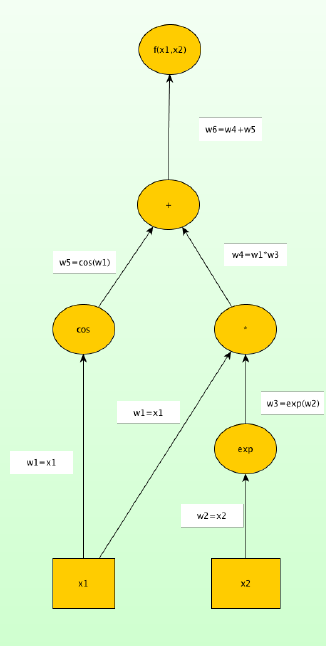

\begin{align}
w_1' &= \textrm{seed} \in {0, 1} \\
w_2' &= \textrm{seed} \in {0, 1} \\
w_3' &= \exp{(w_2)} w_2' \\
w_4' &= w_1' w_3 + w_1 w_3' \\
w_5' &= -\sin{(w_1)} w_1' \\
w_6' &= w_4' + w_5' \\
f'(x_1, x_2) &= w_6'
\end{align}

## Computational Graph for derivatives

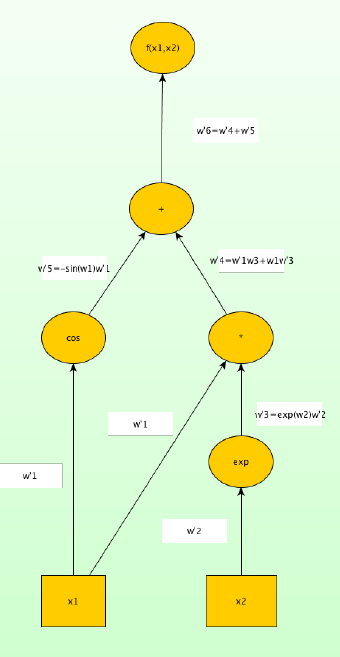

## LLVM Ecosystem

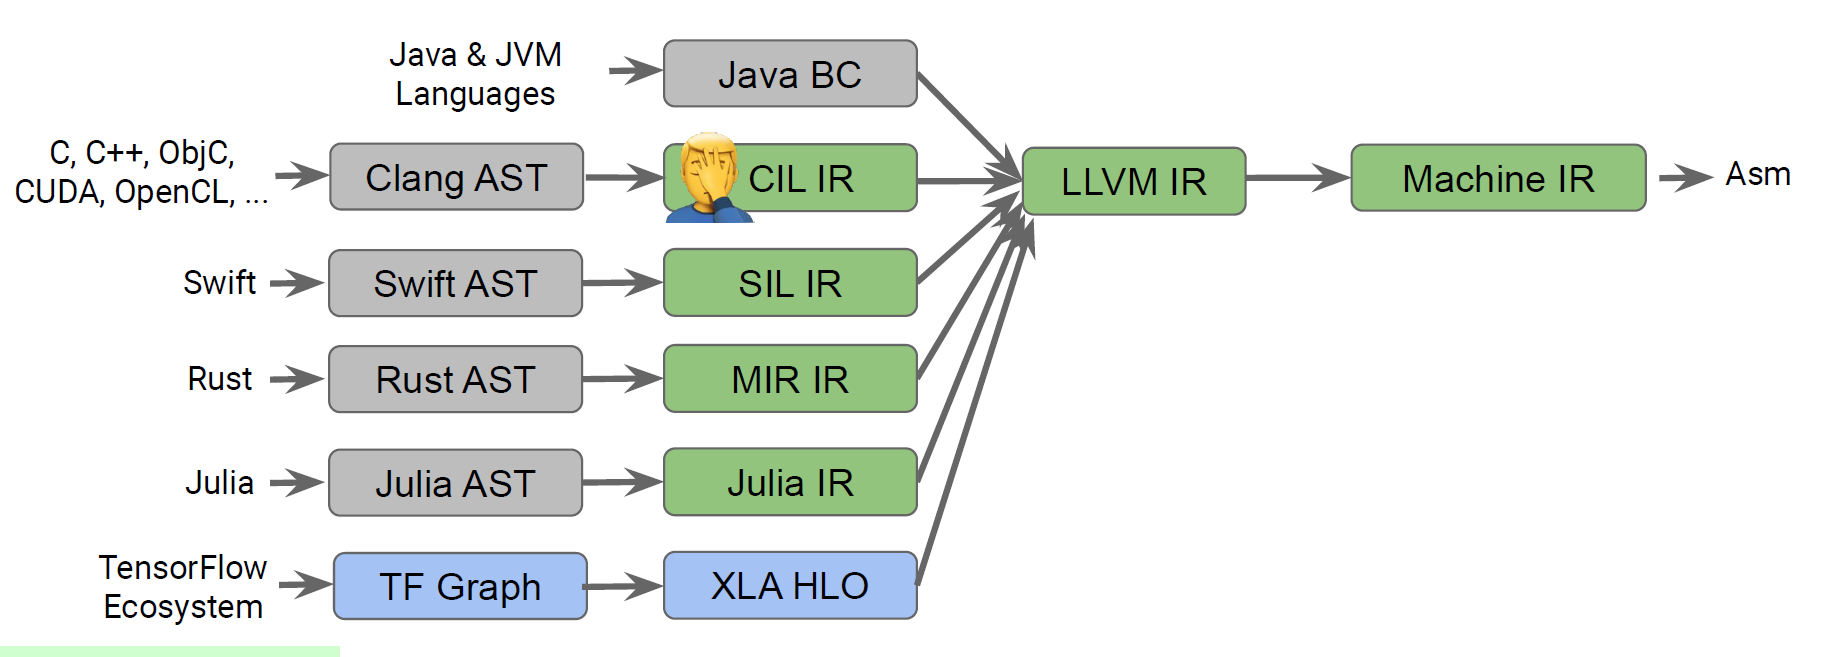

## Tensorflow Compiler Ecosystem

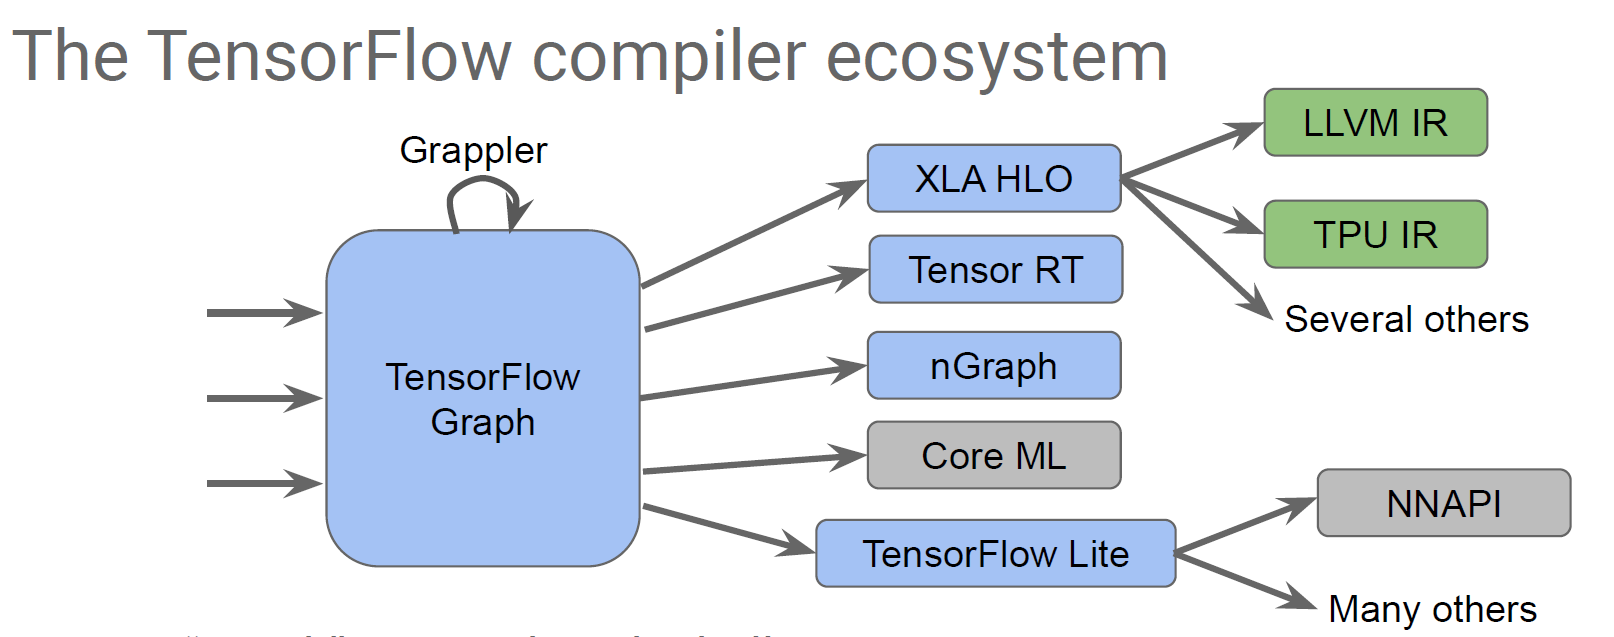

# Conclusion

1. There is some different method to implement computational derivatives
2. Autodifferentiation is not only for machine learning, it could be used various way such as optimal control.
3. Knowing lower level is not manadatory, but this helps to understand whole architecture and create better code
4. Switching langauge is doesn't matter, but only applied for modern language.



##  Reference

* https://github.com/JuliaComputing/JuliaBoxTutorials/blob/master/introductory-tutorials/broader-topics-and-ecosystem/intro-to-ml/20.%20Automatic%20Differentiation%20in%2010%20Minutes.ipynb
* https://www.cs.usask.ca/~spiteri/CMPT898/notes/ad.pdf
* https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf